In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.7 MB/s eta 0:00:00


In [ ]:
import os
import glob
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from types import SimpleNamespace
import albumentations as A
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import timm
import pydicom
from PIL import Image

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

# Stage 1

In [ ]:
coords = pd.read_csv('/content/drive/MyDrive/VIN2025_ML/rsna2024/coords_pretrain.csv')
coords_improved = pd.read_csv('/content/drive/MyDrive/VIN2025_ML/rsna2024/coords_rsna_improved.csv')
coords_improved.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
scs = coords_improved[coords_improved['condition'] == 'Spinal Canal Stenosis']
nfn = coords_improved[(coords_improved['condition'] == 'Left Neural Foraminal Narrowing')  | (coords_improved['condition'] == 'Right Neural Foraminal Narrowing')]
ss = coords_improved[(coords_improved['condition'] == 'Left Subarticular Stenosis')  | (coords_improved['condition'] == 'Right Subarticular Stenosis')]

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/VIN2025_ML/rsna2024/train.csv')
label_train = pd.read_csv('/content/drive/MyDrive/VIN2025_ML/rsna2024/train_label_coordinates.csv')
train_desc = pd.read_csv('/content/drive/MyDrive/VIN2025_ML/rsna2024/train_series_descriptions.csv')

In [ ]:
df_train

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild


In [ ]:
train_desc['series_description'].unique()

array(['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2'], dtype=object)

In [ ]:
sagittal_t1 = train_desc[train_desc['series_description'] == 'Sagittal T1']
sagittal_t2 = train_desc[train_desc['series_description'] == 'Sagittal T2/STIR']
axial_t2 = train_desc[train_desc['series_description'] == 'Axial T2']

In [ ]:
len(sagittal_t2)

1974

In [ ]:
sagittal_t1 = sagittal_t1.merge(coords_improved)
sagittal_t2 = sagittal_t2.merge(coords_improved)
axial_t2 = axial_t2.merge(coords_improved)

In [ ]:
print(sagittal_t1['condition'].unique())
print(sagittal_t2['condition'].unique())
print(axial_t2['condition'].unique())

['Left Neural Foraminal Narrowing' 'Right Neural Foraminal Narrowing'
 'Spinal Canal Stenosis']
['Spinal Canal Stenosis']
['Left Subarticular Stenosis' 'Right Subarticular Stenosis']


In [ ]:
axial_t2[10:20]

,study_id,series_id,series_description,relative_x,relative_y,condition,side,instance_number,level
10,4646740,3201256954,Axial T2,0.612805,0.687718,Left Subarticular Stenosis,R,16,L1/L2
11,4646740,3201256954,Axial T2,0.479638,0.685520,Right Subarticular Stenosis,R,15,L1/L2
12,4646740,3201256954,Axial T2,0.612805,0.663328,Left Subarticular Stenosis,R,22,L2/L3
13,4646740,3201256954,Axial T2,0.523379,0.668929,Right Subarticular Stenosis,R,22,L2/L3
14,4646740,3201256954,Axial T2,0.609321,0.659843,Left Subarticular Stenosis,R,29,L3/L4
15,4646740,3201256954,Axial T2,0.532428,0.658371,Right Subarticular Stenosis,R,28,L3/L4
16,4646740,3201256954,Axial T2,0.579704,0.687718,Left Subarticular Stenosis,R,34,L4/L5
17,4646740,3201256954,Axial T2,0.491704,0.680995,Right Subarticular Stenosis,R,34,L4/L5
18,4646740,3201256954,Axial T2,0.544861,0.729530,Left Subarticular Stenosis,R,40,L5/S1
19,4646740,3201256954,Axial T2,0.449472,0.742836,Right Subarticular Stenosis,R,40,L5/S1


In [ ]:
sagittal_t1[sagittal_t1['condition'] == 'Spinal Canal Stenosis']

,study_id,series_id,series_description,relative_x,relative_y,condition,side,instance_number,level
16772,3637444890,3951475160,Sagittal T1,0.559511,0.285685,Spinal Canal Stenosis,R,8,L1/L2
16775,3637444890,3951475160,Sagittal T1,0.532263,0.391846,Spinal Canal Stenosis,R,8,L2/L3
16778,3637444890,3951475160,Sagittal T1,0.524089,0.506423,Spinal Canal Stenosis,R,8,L3/L4
16781,3637444890,3951475160,Sagittal T1,0.534988,0.608126,Spinal Canal Stenosis,R,8,L4/L5
16784,3637444890,3951475160,Sagittal T1,0.564961,0.692595,Spinal Canal Stenosis,R,8,L5/S1


In [ ]:
sagittal_t2[sagittal_t2['study_id'] == 3637444890]

,study_id,series_id,series_description,relative_x,relative_y,condition,side,instance_number,level


In [ ]:
temp = axial_t2.merge(coords_improved)

In [ ]:
temp[(temp['condition'] == 'Left Subarticular Stenosis')  | (temp['condition'] == 'Right Subarticular Stenosis')]

,study_id,series_id,series_description,relative_x,relative_y,condition,side,instance_number,level
0,4003253,2448190387,Axial T2,0.559770,0.503861,Left Subarticular Stenosis,R,3,L1/L2
1,4003253,2448190387,Axial T2,0.454027,0.495702,Right Subarticular Stenosis,R,4,L1/L2
2,4003253,2448190387,Axial T2,0.565562,0.496139,Left Subarticular Stenosis,R,11,L2/L3
3,4003253,2448190387,Axial T2,0.455938,0.490926,Right Subarticular Stenosis,R,11,L2/L3
4,4003253,2448190387,Axial T2,0.550118,0.492278,Left Subarticular Stenosis,R,19,L3/L4
...,...,...,...,...,...,...,...,...,...
19215,4290709089,3390218084,Axial T2,0.473244,0.556726,Right Subarticular Stenosis,R,10,L3/L4
19216,4290709089,3390218084,Axial T2,0.544068,0.533390,Left Subarticular Stenosis,R,15,L4/L5
19217,4290709089,3390218084,Axial T2,0.477728,0.532063,Right Subarticular Stenosis,R,15,L4/L5
19218,4290709089,3390218084,Axial T2,0.555903,0.576500,Left Subarticular Stenosis,R,20,L5/S1


In [ ]:
scs[scs.groupby(['study_id', 'series_id', 'level'])['instance_number'].transform('count') != 2]

,series_id,relative_x,relative_y,condition,side,instance_number,study_id,level
23882,1753543608,0.545578,0.288357,Spinal Canal Stenosis,R,10,2492114990,L1/L2
23883,1753543608,0.520307,0.420126,Spinal Canal Stenosis,R,10,2492114990,L2/L3
23884,1753543608,0.505866,0.555505,Spinal Canal Stenosis,R,10,2492114990,L3/L4
23885,1753543608,0.500451,0.676444,Spinal Canal Stenosis,R,10,2492114990,L4/L5
23886,1753543608,0.532942,0.788357,Spinal Canal Stenosis,R,10,2492114990,L5/S1
25093,1848483560,0.605072,0.303945,Spinal Canal Stenosis,R,9,2780132468,L1/L2
25094,1848483560,0.592391,0.405395,Spinal Canal Stenosis,R,9,2780132468,L2/L3
25095,1848483560,0.590666,0.506990,Spinal Canal Stenosis,R,9,2780132468,L3/L4
25096,1848483560,0.599609,0.599392,Spinal Canal Stenosis,R,9,2780132468,L4/L5
25097,1848483560,0.619565,0.680757,Spinal Canal Stenosis,R,9,2780132468,L5/S1


In [ ]:
scs.head(10)

,series_id,relative_x,relative_y,condition,side,instance_number,study_id,level
20,370109,0.390625,0.261719,Spinal Canal Stenosis,L,-1,1217477368,L1/L2
21,370109,0.564182,0.282331,Spinal Canal Stenosis,R,9,1217477368,L1/L2
22,370109,0.367188,0.398438,Spinal Canal Stenosis,L,-1,1217477368,L2/L3
23,370109,0.546010,0.413573,Spinal Canal Stenosis,R,9,1217477368,L2/L3
24,370109,0.339844,0.531250,Spinal Canal Stenosis,L,-1,1217477368,L3/L4
25,370109,0.528847,0.536739,Spinal Canal Stenosis,R,9,1217477368,L3/L4
26,370109,0.335938,0.671875,Spinal Canal Stenosis,L,-1,1217477368,L4/L5
27,370109,0.541972,0.633656,Spinal Canal Stenosis,R,9,1217477368,L4/L5
28,370109,0.390625,0.796875,Spinal Canal Stenosis,L,-1,1217477368,L5/S1
29,370109,0.557115,0.732592,Spinal Canal Stenosis,R,9,1217477368,L5/S1


## Dataset cho SCS

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import pydicom
import numpy as np
from collections import defaultdict
import cv2

class Stage1DatasetSCS(Dataset):
    def __init__(self, image_root, df, transform=None, target_size=512):
        """
        Args:
            csv_file (str): đường dẫn file CSV chứa keypoints
            image_root (str): thư mục gốc chứa train_images
            transform: augmentations (albumentations, v.v.)
            drop_ids (list): danh sách study_id cần loại bỏ
            target_size (int): resize ảnh về kích thước vuông (default=512)
        """
        # Bỏ dòng instance_number = -1 (chỉ có toạ độ ảo, không có ảnh)
        df = df[df["instance_number"] != -1]

        self.image_root = image_root
        self.transform = transform
        self.target_size = target_size

        # Gom keypoints theo từng ảnh
        grouped = defaultdict(list)
        for _, row in df.iterrows():
            key = (row["study_id"], row["series_id"], row["instance_number"])
            grouped[key].append((row["relative_x"], row["relative_y"]))

        self.samples = []
        for (study_id, series_id, instance_number), points in grouped.items():
            self.samples.append({
                "study_id": study_id,
                "series_id": series_id,
                "instance_number": instance_number,
                "points": points
            })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        study_id = str(sample["study_id"])
        series_id = str(sample["series_id"])
        instance_number = str(sample["instance_number"])

        # Load DICOM ảnh gốc
        dcm_path = os.path.join(self.image_root, study_id, series_id, f"{instance_number}.dcm")
        dcm = pydicom.dcmread(dcm_path)
        image = dcm.pixel_array.astype(np.float32)

        h, w = image.shape

        # Chuyển relative_x, relative_y → pixel
        keypoints = []
        for rx, ry in sample["points"]:
            x = rx * w
            y = ry * h
            keypoints.append([x, y])
        keypoints = np.array(keypoints, dtype=np.float32)

        # Resize ảnh và keypoints (nếu target_size != None)
        if self.target_size is not None:
            image_resized = cv2.resize(image, (self.target_size, self.target_size))
            scale_x = self.target_size / w
            scale_y = self.target_size / h
            keypoints[:, 0] = keypoints[:, 0] * scale_x
            keypoints[:, 1] = keypoints[:, 1] * scale_y
        else:
            image_resized = image

        # Chuyển thành 3 kênh
        image_resized = np.stack([image_resized]*3, axis=-1)

        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image_resized, keypoints=keypoints)
            image_resized = transformed["image"]
            keypoints = np.array(transformed["keypoints"], dtype=np.float32)

        # Convert sang tensor
        image_resized = torch.tensor(image_resized).permute(2,0,1).float()   # (3,H,W)
        keypoints = torch.tensor(keypoints).float()                         # (N,2)

        return image_resized, keypoints


In [ ]:
from torch.utils.data import DataLoader

dataset = Stage1DatasetSCS(TRAIN_DIR, scs)
loader = DataLoader(dataset, batch_size=2, shuffle=False)

for imgs, keypoints in loader:
    print(imgs.shape, keypoints)  # (B,1,H,W)
    break

torch.Size([2, 3, 512, 512]) tensor([[[288.8611, 144.5533],
         [279.5570, 211.7493],
         [270.7698, 274.8102],
         [277.4894, 324.4318],
         [285.2428, 375.0873]],

        [[274.6358, 181.4023],
         [256.4387, 237.6478],
         [253.9573, 304.6462],
         [272.1544, 351.7932],
         [298.6229, 406.3845]]])


In [ ]:
dataset = Stage1DatasetSCS(TRAIN_DIR, scs)
img, kps = dataset[0]
print(img.shape)     # (3,H,W)
print(kps)

torch.Size([3, 512, 512])
tensor([[288.8611, 144.5533],
        [279.5570, 211.7493],
        [270.7698, 274.8102],
        [277.4894, 324.4318],
        [285.2428, 375.0873]])


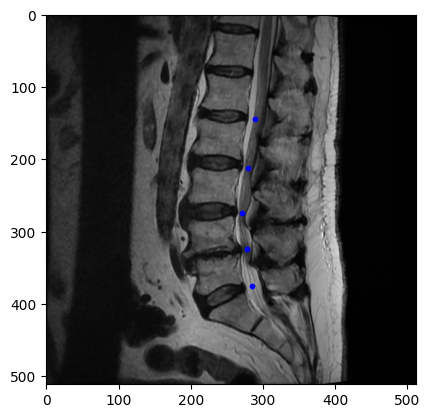

In [ ]:
plt.imshow(img.cpu().numpy()[0, :, :], cmap='gray') # Assuming the image is grayscale with 1 channel
plt.scatter([x[0] for x in kps.cpu().numpy()], [x[1] for x in kps.cpu().numpy()], c='blue', marker='o', s=10) # Explicitly set color, marker, and size
plt.show()

## Xử lý df

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/VIN2025_ML/rsna2024/train.csv')
label_train = pd.read_csv('/content/drive/MyDrive/VIN2025_ML/rsna2024/train_label_coordinates.csv')
train_desc = pd.read_csv('/content/drive/MyDrive/VIN2025_ML/rsna2024/train_series_descriptions.csv')
coords_improved = pd.read_csv('/content/drive/MyDrive/VIN2025_ML/rsna2024/coords_rsna_improved.csv')
coords_improved.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
sagittal_t1 = train_desc[train_desc['series_description'] == 'Sagittal T1']
sagittal_t2 = train_desc[train_desc['series_description'] == 'Sagittal T2/STIR']
axial_t2 = train_desc[train_desc['series_description'] == 'Axial T2']

sagittal_t1 = sagittal_t1.merge(coords_improved)
sagittal_t2 = sagittal_t2.merge(coords_improved)
axial_t2 = axial_t2.merge(coords_improved)

In [ ]:
axial_t2

,study_id,series_id,series_description,relative_x,relative_y,condition,side,instance_number,level
0,4003253,2448190387,Axial T2,0.559770,0.503861,Left Subarticular Stenosis,R,3,L1/L2
1,4003253,2448190387,Axial T2,0.454027,0.495702,Right Subarticular Stenosis,R,4,L1/L2
2,4003253,2448190387,Axial T2,0.565562,0.496139,Left Subarticular Stenosis,R,11,L2/L3
3,4003253,2448190387,Axial T2,0.455938,0.490926,Right Subarticular Stenosis,R,11,L2/L3
4,4003253,2448190387,Axial T2,0.550118,0.492278,Left Subarticular Stenosis,R,19,L3/L4
...,...,...,...,...,...,...,...,...,...
19215,4290709089,3390218084,Axial T2,0.473244,0.556726,Right Subarticular Stenosis,R,10,L3/L4
19216,4290709089,3390218084,Axial T2,0.544068,0.533390,Left Subarticular Stenosis,R,15,L4/L5
19217,4290709089,3390218084,Axial T2,0.477728,0.532063,Right Subarticular Stenosis,R,15,L4/L5
19218,4290709089,3390218084,Axial T2,0.555903,0.576500,Left Subarticular Stenosis,R,20,L5/S1


In [ ]:
df_train.fillna(' ', inplace=True)

In [ ]:
sagittal_t1.head(10)

,study_id,series_id,series_description,relative_x,relative_y,condition,side,instance_number,level
0,4003253,1054713880,Sagittal T1,0.510601,0.328180,Left Neural Foraminal Narrowing,L,11,L1/L2
1,4003253,1054713880,Sagittal T1,0.506692,0.332696,Right Neural Foraminal Narrowing,R,6,L1/L2
2,4003253,1054713880,Sagittal T1,0.498233,0.443021,Left Neural Foraminal Narrowing,L,12,L2/L3
3,4003253,1054713880,Sagittal T1,0.499044,0.432122,Right Neural Foraminal Narrowing,R,6,L2/L3
4,4003253,1054713880,Sagittal T1,0.489267,0.565742,Left Neural Foraminal Narrowing,L,12,L3/L4
5,4003253,1054713880,Sagittal T1,0.487572,0.548757,Right Neural Foraminal Narrowing,R,5,L3/L4
6,4003253,1054713880,Sagittal T1,0.485689,0.655188,Left Neural Foraminal Narrowing,L,11,L4/L5
7,4003253,1054713880,Sagittal T1,0.489484,0.655832,Right Neural Foraminal Narrowing,R,4,L4/L5
8,4003253,1054713880,Sagittal T1,0.513283,0.753795,Left Neural Foraminal Narrowing,L,11,L5/S1
9,4003253,1054713880,Sagittal T1,0.516252,0.743786,Right Neural Foraminal Narrowing,R,4,L5/S1


In [ ]:
temp1 = sagittal_t1.groupby(['study_id', 'series_id', 'side']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')
temp2 = sagittal_t1.groupby(['study_id', 'series_id', 'side']).apply(lambda x: sum(x['instance_number'])//len(x)).reset_index(name='instance_number')

scs = df_train.iloc[:, :6]
l_nfn = df_train.iloc[:, [0, 6, 7, 8, 9, 10]]
r_nfn = df_train.iloc[:, [0, 11, 12, 13, 14, 15]]
l_ss = df_train.iloc[:, [0, 16, 17, 18, 19, 20]]
r_ss = df_train.iloc[:, [0, 21, 22, 23, 24, 25]]

scs.columns = ['study_id', '0', '1', '2', '3', '4']
l_nfn.columns = ['study_id', '0', '1', '2', '3', '4']
r_nfn.columns = ['study_id', '0', '1', '2', '3', '4']
l_ss.columns = ['study_id', '0', '1', '2', '3', '4']
r_ss.columns = ['study_id', '0', '1', '2', '3', '4']

temp3 = temp1.merge(temp2)
temp3['file_path'] = temp3.apply(lambda x: os.path.join(str(x['study_id']), str(x['series_id']), str(x['instance_number']) + '.dcm'), axis=1)

temp3['scs'] = temp3.merge(scs).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['l_nfn'] = temp3.merge(l_nfn).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['r_nfn'] = temp3.merge(r_nfn).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['l_ss'] = temp3.merge(l_ss).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['r_ss'] = temp3.merge(r_ss).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)

sagittal_t1_crop = temp3

/tmp/ipython-input-34923942.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp1 = sagittal_t1.groupby(['study_id', 'series_id', 'side']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')
/tmp/ipython-input-34923942.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp2 = sagittal_t1.groupby(['study_id', 'series_id', 'side']).apply(lambda x: sum(x['instance_numb

In [ ]:
sagittal_t1_crop.head()

,study_id,series_id,side,coords,instance_number,file_path,scs,l_nfn,r_nfn,l_ss,r_ss
0,4003253,1054713880,L,"[(0.510600707, 0.328180212), (0.498233216, 0.4...",11,4003253/1054713880/11.dcm,"[(N, N, N, N, N)]","[(N, N, N, M, N)]","[(N, N, M, M, N)]","[(N, N, N, M, N)]","[(N, N, N, N, N)]"
1,4003253,1054713880,R,"[(0.506692161, 0.332695985), (0.499043977, 0.4...",5,4003253/1054713880/5.dcm,"[(N, N, N, N, N)]","[(N, N, N, M, N)]","[(N, N, M, M, N)]","[(N, N, N, M, N)]","[(N, N, N, N, N)]"
2,4646740,3486248476,L,"[(0.626783014, 0.257839761), (0.609633623, 0.3...",5,4646740/3486248476/5.dcm,"[(N, N, M, S, N)]","[(N, N, N, M, M)]","[(N, N, M, M, N)]","[(N, N, N, S, N)]","[(N, M, M, M, N)]"
3,4646740,3486248476,R,"[(0.622343335, 0.270243791), (0.578518862, 0.3...",16,4646740/3486248476/16.dcm,"[(N, N, M, S, N)]","[(N, N, N, M, M)]","[(N, N, M, M, N)]","[(N, N, N, S, N)]","[(N, M, M, M, N)]"
4,7143189,3219733239,L,"[(0.547664196, 0.272829157), (0.536405631, 0.3...",12,7143189/3219733239/12.dcm,"[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]"


In [ ]:
temp1 = sagittal_t2.groupby(['study_id', 'series_id', 'side']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')
temp2 = sagittal_t2[sagittal_t2['side'] == 'R']
temp2 = temp2.groupby(['study_id', 'series_id', 'side']).apply(lambda x: sum(x['instance_number'])//len(x)).reset_index(name='instance_number')

scs = df_train.iloc[:, :6]
l_nfn = df_train.iloc[:, [0, 6, 7, 8, 9, 10]]
r_nfn = df_train.iloc[:, [0, 11, 12, 13, 14, 15]]
l_ss = df_train.iloc[:, [0, 16, 17, 18, 19, 20]]
r_ss = df_train.iloc[:, [0, 21, 22, 23, 24, 25]]

scs.columns = ['study_id', '0', '1', '2', '3', '4']
l_nfn.columns = ['study_id', '0', '1', '2', '3', '4']
r_nfn.columns = ['study_id', '0', '1', '2', '3', '4']
l_ss.columns = ['study_id', '0', '1', '2', '3', '4']
r_ss.columns = ['study_id', '0', '1', '2', '3', '4']

temp3 = temp1.merge(temp2)
temp3['file_path'] = temp3.apply(lambda x: os.path.join(str(x['study_id']), str(x['series_id']), str(x['instance_number']) + '.dcm'), axis=1)

temp3['scs'] = temp3.merge(scs).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['l_nfn'] = temp3.merge(l_nfn).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['r_nfn'] = temp3.merge(r_nfn).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['l_ss'] = temp3.merge(l_ss).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['r_ss'] = temp3.merge(r_ss).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)

sagittal_t2_crop = temp3

/tmp/ipython-input-1566877174.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp1 = sagittal_t2.groupby(['study_id', 'series_id', 'side']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')
/tmp/ipython-input-1566877174.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp2 = temp2.groupby(['study_id', 'series_id', 'side']).apply(lambda x: sum(x['instance_number

In [ ]:
sagittal_t2_crop.head()

,study_id,series_id,side,coords,instance_number,file_path,scs,l_nfn,r_nfn,l_ss,r_ss
0,4003253,702807833,R,"[(0.504424779, 0.35619469), (0.500892857, 0.46...",8,4003253/702807833/8.dcm,"[(N, N, N, N, N)]","[(N, N, N, M, N)]","[(N, N, M, M, N)]","[(N, N, N, M, N)]","[(N, N, N, N, N)]"
1,4646740,3666319702,R,"[(0.629427191, 0.289215686), (0.616893768, 0.4...",10,4646740/3666319702/10.dcm,"[(N, N, M, S, N)]","[(N, N, N, M, M)]","[(N, N, M, M, N)]","[(N, N, N, S, N)]","[(N, M, M, M, N)]"
2,7143189,132939515,R,"[(0.556057713, 0.292898133), (0.537979692, 0.4...",9,7143189/132939515/9.dcm,"[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]"
3,8785691,481125819,R,"[(0.568548387, 0.301523298), (0.538082437, 0.4...",8,8785691/481125819/8.dcm,"[(N, N, N, N, N)]","[(N, N, N, M, M)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]"
4,10728036,3491739931,R,"[(0.580899374, 0.290849673), (0.578720724, 0.4...",11,10728036/3491739931/11.dcm,"[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, M, N)]"


In [ ]:
axial_t2.head(10)

,study_id,series_id,series_description,relative_x,relative_y,condition,side,instance_number,level
0,4003253,2448190387,Axial T2,0.559770,0.503861,Left Subarticular Stenosis,R,3,L1/L2
1,4003253,2448190387,Axial T2,0.454027,0.495702,Right Subarticular Stenosis,R,4,L1/L2
2,4003253,2448190387,Axial T2,0.565562,0.496139,Left Subarticular Stenosis,R,11,L2/L3
3,4003253,2448190387,Axial T2,0.455938,0.490926,Right Subarticular Stenosis,R,11,L2/L3
4,4003253,2448190387,Axial T2,0.550118,0.492278,Left Subarticular Stenosis,R,19,L3/L4
5,4003253,2448190387,Axial T2,0.446387,0.488061,Right Subarticular Stenosis,R,19,L3/L4
6,4003253,2448190387,Axial T2,0.540465,0.490347,Left Subarticular Stenosis,R,28,L4/L5
7,4003253,2448190387,Axial T2,0.460713,0.493792,Right Subarticular Stenosis,R,28,L4/L5
8,4003253,2448190387,Axial T2,0.561701,0.505792,Left Subarticular Stenosis,R,35,L5/S1
9,4003253,2448190387,Axial T2,0.455938,0.504298,Right Subarticular Stenosis,R,35,L5/S1


In [ ]:
temp2 = axial_t2[axial_t2.groupby(['study_id', 'series_id', 'level'])['condition'].transform('count') == 1]

temp3 = temp2.groupby(['study_id', 'level']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')

temp2_l = temp2[temp2['condition'] == 'Left Subarticular Stenosis']

temp3 = temp3.merge(temp2_l)
temp3.drop(['condition', 'series_description', 'relative_x', 'relative_y'], axis=1, inplace=True)

scs = df_train.iloc[:, :6]
l_nfn = df_train.iloc[:, [0, 6, 7, 8, 9, 10]]
r_nfn = df_train.iloc[:, [0, 11, 12, 13, 14, 15]]
l_ss = df_train.iloc[:, [0, 16, 17, 18, 19, 20]]
r_ss = df_train.iloc[:, [0, 21, 22, 23, 24, 25]]

scs.columns = ['study_id', '0', '1', '2', '3', '4']
l_nfn.columns = ['study_id', '0', '1', '2', '3', '4']
r_nfn.columns = ['study_id', '0', '1', '2', '3', '4']
l_ss.columns = ['study_id', '0', '1', '2', '3', '4']
r_ss.columns = ['study_id', '0', '1', '2', '3', '4']

temp3['file_path'] = temp3.apply(lambda x: os.path.join(str(x['study_id']), str(x['series_id']), str(x['instance_number']) + '.dcm'), axis=1)

temp3['scs'] = temp3.merge(scs).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['l_nfn'] = temp3.merge(l_nfn).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['r_nfn'] = temp3.merge(r_nfn).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['l_ss'] = temp3.merge(l_ss).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['r_ss'] = temp3.merge(r_ss).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)

axial_t2_crop = temp3

/tmp/ipython-input-1390252773.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp3 = temp2.groupby(['study_id', 'level']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')


In [ ]:
axial_t2_crop[axial_t2_crop['coords'].apply(lambda x: len(x)) == 1]

,study_id,level,coords,series_id,side,instance_number,file_path,scs,l_nfn,r_nfn,l_ss,r_ss
231,1143209760,L1/L2,"[(0.52757276, 0.541038526)]",2136402509,R,1,1143209760/2136402509/1.dcm,"[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, M, M)]","[(N, N, N, M, S)]","[( , N, N, S, M)]"
669,3515641631,L2/L3,"[(0.5546875, 0.586309524)]",2671592485,R,3,3515641631/2671592485/3.dcm,"[(N, M, N, M, N)]","[(N, M, N, M, M)]","[(N, N, S, S, N)]","[( , M, M, S, N)]","[( , , N, M, M)]"


In [ ]:
axial_t2[axial_t2['study_id'] == 1143209760]

,study_id,series_id,series_description,relative_x,relative_y,condition,side,instance_number,level
5094,1143209760,2136402509,Axial T2,0.527573,0.541039,Left Subarticular Stenosis,R,1,L1/L2
5095,1143209760,2136402509,Axial T2,0.524223,0.517588,Left Subarticular Stenosis,R,8,L2/L3
5096,1143209760,2136402509,Axial T2,0.438101,0.520811,Right Subarticular Stenosis,R,8,L2/L3
5097,1143209760,2136402509,Axial T2,0.527573,0.507538,Left Subarticular Stenosis,R,16,L3/L4
5098,1143209760,2136402509,Axial T2,0.442600,0.499445,Right Subarticular Stenosis,R,17,L3/L4
5099,1143209760,2136402509,Axial T2,0.509147,0.536013,Left Subarticular Stenosis,R,26,L4/L5
5100,1143209760,2136402509,Axial T2,0.438101,0.541053,Right Subarticular Stenosis,R,26,L4/L5
5101,1143209760,2136402509,Axial T2,0.510822,0.527638,Left Subarticular Stenosis,R,34,L5/S1
5102,1143209760,2136402509,Axial T2,0.431354,0.525309,Right Subarticular Stenosis,R,34,L5/S1


In [ ]:
axial_t2[axial_t2['study_id'] == 3515641631]

,study_id,series_id,series_description,relative_x,relative_y,condition,side,instance_number,level
15781,3515641631,830954747,Axial T2,0.584930,0.568380,Left Subarticular Stenosis,R,3,L3/L4
15782,3515641631,830954747,Axial T2,0.510677,0.568519,Right Subarticular Stenosis,R,3,L3/L4
15783,3515641631,830954747,Axial T2,0.587544,0.550958,Left Subarticular Stenosis,R,9,L4/L5
15784,3515641631,830954747,Axial T2,0.499566,0.561111,Right Subarticular Stenosis,R,8,L4/L5
15785,3515641631,830954747,Axial T2,0.574477,0.519599,Left Subarticular Stenosis,R,12,L5/S1
15786,3515641631,830954747,Axial T2,0.488455,0.537037,Right Subarticular Stenosis,R,12,L5/S1
15787,3515641631,2671592485,Axial T2,0.554688,0.586310,Left Subarticular Stenosis,R,3,L2/L3


In [ ]:
"1143209760", "3515641631"

('1143209760', '3515641631')

In [ ]:
axial_t2_crop = axial_t2_crop[axial_t2_crop['study_id'] != 1143209760]
axial_t2_crop = axial_t2_crop[axial_t2_crop['study_id'] != 3515641631]

In [ ]:
axial_t2_crop['center'] = axial_t2_crop["coords"].apply(lambda pts: ((pts[0][0] + pts[1][0]) / 2,
                                               (pts[0][1] + pts[1][1]) / 2))

In [ ]:
axial_t2_crop.head()

,study_id,level,coords,series_id,side,instance_number,file_path,scs,l_nfn,r_nfn,l_ss,r_ss,center
0,10728036,L1/L2,"[(0.567492157, 0.49034749), (0.455937631, 0.48...",142859125,R,8,10728036/142859125/8.dcm,"[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, M, N)]","(0.511714894, 0.48824919850000004)"
1,10728036,L2/L3,"[(0.553978644, 0.498069498), (0.45784785, 0.50...",142859125,R,15,10728036/142859125/15.dcm,"[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, M, N)]","(0.505913247, 0.4992735265)"
2,10728036,L3/L4,"[(0.544326134, 0.5), (0.447341642, 0.486150907)]",142859125,R,20,10728036/142859125/20.dcm,"[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, M, N)]","(0.49583388799999994, 0.49307545350000004)"
3,10728036,L4/L5,"[(0.534673625, 0.482625483), (0.45880296, 0.47...",142859125,R,27,10728036/142859125/27.dcm,"[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, M, N)]","(0.4967382925, 0.4777024265)"
4,10728036,L5/S1,"[(0.548187138, 0.474903475), (0.45784785, 0.51...",142859125,R,33,10728036/142859125/33.dcm,"[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, M, N)]","(0.503017494, 0.49246606400000004)"


## Crop chỉ với 1 điểm bên phải

In [ ]:
import numpy as np
import cv2
from scipy.interpolate import splprep, splev

def crop_centered_patches(image, keypoints, box_width=150, box_height=100):
    """
    Crop patch quanh mỗi keypoint, patch được căn chỉnh theo spline.
    Args:
        image: numpy array (H,W)
        keypoints: list [(x,y), ...] tọa độ pixel disc levels
        box_width: chiều rộng patch (vuông góc spline)
        box_height: chiều dài patch (dọc spline)
    Return:
        list các patch crop quanh từng keypoint
    """
    keypoints = np.array(keypoints)
    x, y = keypoints[:,0], keypoints[:,1]

    # Fit spline qua các keypoint
    tck, u = splprep([x, y], s=0, k=min(3, len(keypoints)-1))

    patches = []
    for i, (px, py) in enumerate(keypoints):
        # Tham số u gần nhất với keypoint
        ui = u[i]
        dx, dy = splev(ui, tck, der=1)  # vector tiếp tuyến tại keypoint
        tangent = np.array([dx, dy], dtype=np.float32)
        tangent /= np.linalg.norm(tangent)

        # vector pháp tuyến
        normal = np.array([-tangent[1], tangent[0]])

        # 4 điểm box centered tại keypoint
        p1 = (px - tangent[0]*box_height/2 + normal[0]*box_width/2,
              py - tangent[1]*box_height/2 + normal[1]*box_width/2)
        p2 = (p1 - normal*box_width)
        p3 = (px + tangent[0]*box_height/2 - normal[0]*box_width/2,
              py + tangent[1]*box_height/2 - normal[1]*box_width/2)
        p4 = (px + tangent[0]*box_height/2 + normal[0]*box_width/2,
              py + tangent[1]*box_height/2 + normal[1]*box_width/2)

        src_pts = np.array([p1,p2,p3,p4], dtype=np.float32)
        dst_pts = np.array([[0,0],[box_width,0],[box_width,box_height],[0,box_height]], dtype=np.float32)

        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        patch = cv2.warpPerspective(image, M, (box_width, box_height))
        patches.append(patch)

    return patches